In [1]:
pwd

'C:\\Users\\user'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import time
import sys
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
from tensorboard import notebook
%load_ext tensorboard

from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils.layer_utils import count_params

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard


Using TensorFlow backend.


In [4]:
# Define Image Augmentation and Training Parameters

class Config:
    # Data Augmentation Parameters
    DATA_AUG_ON = False
    DATA_AUG_ROTATE = 20
    DATA_AUG_FLIP = True
    DATA_AUG_WIDTH_SHIFT = 0.2
    DATA_AUG_HEIGHT_SHIFT = 0.2
    DATA_AUG_ZOOM = 0.2
    DATA_AUG_SHEAR = 0.2
    # Epoch to start learning rate decay
    MODEL_TRAIN_DECAY = True
    MODEL_START_DECAY = 1
    # Exponential Learning Rate Decay
    MODEL_DECAY_EXPONENTIAL = True
    MODEL_PERCENT_DECAY = 0.1
    # Drop-Based Learning Rate Decay
    MODEL_DECAY_DROP = False
    MODEL_DROP_RATE = 0.5
    MODEL_EPOCH_DROP = 10
    # General Model Parameters
    MODEL_TRAIN_EPOCHS = [20]
    MODEL_TRAIN_LEARN_RATE = [0.005]
    MODEL_TRAIN_BATCH_SIZE = 32
    MODEL_TRAIN_FIRST_TRAINABLE_LAYER = 250
    
config = Config()

In [5]:
# Define Base Model

base_model = InceptionV3(weights = 'imagenet', include_top = False)

MODEL_TRAINABLE_BASE = True

if MODEL_TRAINABLE_BASE:
    base_model.trainable = True
    if config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER:
        for layer in base_model.layers[:config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER]:
            layer.trainable = False
        for layer in base_model.layers[config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER:]:
            layer.trainable = True
else:
    base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(5e-3),
                bias_regularizer = regularizers.l2(5e-3))(x)
x = Dense(1, activation = 'sigmoid', name = 'output')(x)

model = Model(inputs = base_model.input, outputs = x)

# print(model.summary())

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total Parameters: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable Parameters: {:,}'.format(trainable_count))
print('Non-Trainable Parameters: {:,}'.format(non_trainable_count))

Total Parameters: 21,942,177
Trainable Parameters: 10,676,737
Non-Trainable Parameters: 11,265,440


In [6]:
# datagen = ImageDataGenerator(rescale = 1./255.,
#                              rotation_range = config.DATA_AUG_ROTATE,
#                              horizontal_flip = config.DATA_AUG_FLIP,
#                              width_shift_range = config.DATA_AUG_WIDTH_SHIFT,
#                              height_shift_range = config.DATA_AUG_HEIGHT_SHIFT,
#                              zoom_range = config.DATA_AUG_ZOOM,
#                              shear_range = config.DATA_AUG_SHEAR)

# image = 'G:\\video_unique'
# output = 'G:\\video_unique_aug\\in_aug'

# imageGen = datagen.flow_from_directory(image, 
#                         target_size = (299,299),
#                         color_mode = 'rgb',
#                         batch_size = 1,
#                         save_to_dir = output,
#                         save_prefix = 'in',
#                         save_format = 'jpg')

In [7]:
# total = 0
# for image in imageGen:
#     total += 1
#     if total == imageGen.n*10:
#         break

In [8]:
if config.DATA_AUG_ON:
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       validation_split = 0.2,
                                       rotation_range = config.DATA_AUG_ROTATE,
                                       horizontal_flip = config.DATA_AUG_FLIP,
                                       width_shift_range = config.DATA_AUG_WIDTH_SHIFT,
                                       height_shift_range = config.DATA_AUG_HEIGHT_SHIFT,
                                       zoom_range = config.DATA_AUG_ZOOM,
                                       shear_range = config.DATA_AUG_SHEAR)

else:
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       validation_split = 0.2)
    
valid_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)
    
train_generator = train_datagen.flow_from_directory('C:\\Users\\user\\chair_model\\training',
                                              target_size = (299, 299),
                                              color_mode = 'rgb',
                                              classes = ['emptyChair', 'inChair'],
                                              batch_size = config.MODEL_TRAIN_BATCH_SIZE,
                                              seed = 724,
                                              class_mode = 'binary',
                                              subset = 'training',
                                              shuffle = True)

validation_generator = train_datagen.flow_from_directory('C:\\Users\\user\\chair_model\\training',
                                              target_size = (299, 299),
                                              color_mode = 'rgb',
                                              classes = ['emptyChair', 'inChair'],
                                              batch_size = config.MODEL_TRAIN_BATCH_SIZE,
                                              seed = 724,
                                              class_mode = 'binary',
                                              subset = 'validation',
                                              shuffle = False)

test_generator = test_datagen.flow_from_directory('C:\\Users\\user\\chair_model\\labVideos',
                                              target_size = (299, 299),
                                              color_mode = 'rgb',
                                              seed = 724,
                                              batch_size = 1,
                                              class_mode = None,
                                              shuffle = False)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

train_generator.class_indices

Found 5344 images belonging to 2 classes.
Found 1335 images belonging to 2 classes.
Found 488 images belonging to 1 classes.


{'emptyChair': 0, 'inChair': 1}

In [9]:
def show_batch(image, label):
    plt.figure(figsize = (10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.title(int(label[n]))
        plt.imshow(image[n])
        plt.axis('off')

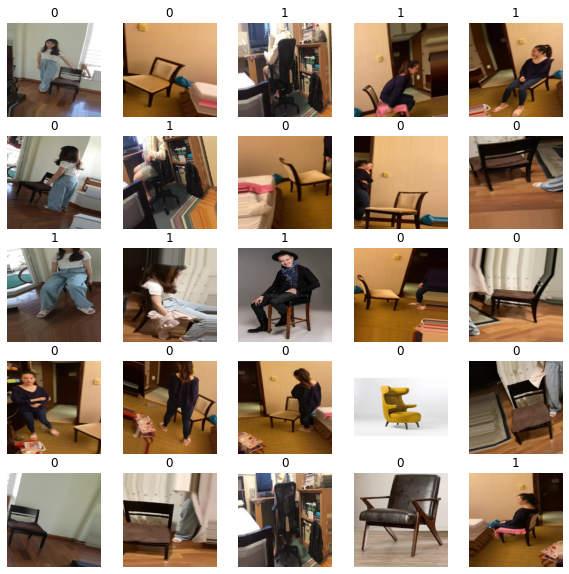

In [10]:
image_batch, label_batch = train_generator.next()
show_batch(image_batch, label_batch)

In [11]:
model.compile(optimizer = Adam(lr = config.MODEL_TRAIN_LEARN_RATE[0]),
              loss = losses.BinaryCrossentropy(),
              metrics = ['binary_accuracy'])

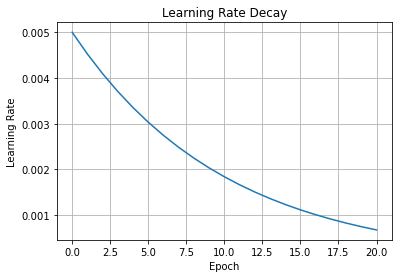

In [12]:
# Learning Rate Decay Graph
decay = []
def scheduler(epoch):
    learn_rate = config.MODEL_TRAIN_LEARN_RATE[0]
    total_epochs = config.MODEL_TRAIN_EPOCHS[0]
    
    if config.MODEL_TRAIN_DECAY:
        
        if epoch < config.MODEL_START_DECAY:
            value = learn_rate
            decay.append(value)
            return value
        
        else:
            if config.MODEL_DECAY_EXPONENTIAL: 
                value = learn_rate * tf.math.exp(
                        config.MODEL_PERCENT_DECAY * (config.MODEL_START_DECAY - epoch))
                
            if config.MODEL_DECAY_DROP:
                value = learn_rate * np.power(
                        config.MODEL_DROP_RATE, np.floor((1+epoch)/ config.MODEL_EPOCH_DROP))
                
            decay.append(value)
            return value
        
    else:
        return config.MODEL_TRAIN_LEARN_RATE[0]

for x in np.arange(0, config.MODEL_TRAIN_EPOCHS[0] + 1):
    scheduler(x)
    
plt.plot(np.linspace(1, config.MODEL_TRAIN_EPOCHS[0], config.MODEL_TRAIN_EPOCHS[0] + 1), decay)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay')
plt.grid()
plt.show()

In [13]:
# DIFFERENT CALLBACK FUNCTIONS

# Display Learning Rate Each Epoch
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print('\nEpoch Learning Rate: ', K.eval(lr_with_decay))
        
# Reduced learning rate when metric has stopped improving
reduced_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5,
                               patience = 5, min_lr = 0.0001, verbose = 1)

# Early stopping when monitored quantity has stopped improving
early_stop = EarlyStopping()

# Tensorboard Callback
logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq = 1)

learning_rate_scheduler = LearningRateScheduler(scheduler, verbose = 0)
call_learning_rate = MyCallback()

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = validation_generator,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = config.MODEL_TRAIN_EPOCHS[0],
                              callbacks = [learning_rate_scheduler, tensorboard_callback, call_learning_rate],
                              verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 167 steps, validate for 41 steps
Epoch 1/20


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


166/167 [============================>.] - ETA: 0s - loss: 0.5614 - binary_accuracy: 0.9330
Epoch Learning Rate:  0.005
167/167 [==============================] - 86s 515ms/step - loss: 0.5615 - binary_accuracy: 0.9332 - val_loss: 1.1933 - val_binary_accuracy: 0.9306
Epoch 2/20
166/167 [============================>.] - ETA: 0s - loss: 0.0606 - binary_accuracy: 0.9906
Epoch Learning Rate:  0.0045241867
167/167 [==============================] - 75s 449ms/step - loss: 0.0603 - binary_accuracy: 0.9906 - val_loss: 0.1367 - val_binary_accuracy: 0.9627
Epoch 3/20
166/167 [============================>.] - ETA: 0s - loss: 0.0212 - binary_accuracy: 0.9964
Epoch Learning Rate:  0.004093654
167/167 [==============================] - 76s 454ms/step - loss: 0.0211 - binary_accuracy: 0.9964 - val_loss: 0.1134 - val_binary_accuracy: 0.9756
Epoch 4/20
166/167 [============================>.] - ETA: 0s - loss: 0.0266 - binary_accuracy: 0.9944
Epoch Learning Rate:  0.0037040906
167/167 [==============

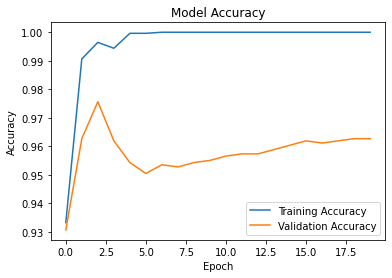

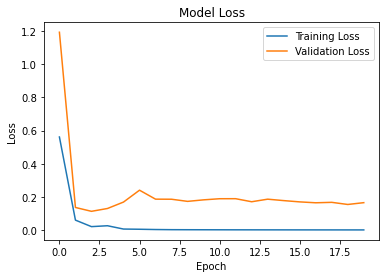

In [14]:
plt.figure(1)

plt.plot(history.history['binary_accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure(2)

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [20]:
# model = load_model('C:\\Users\\user\\saved_models\\basic_alldata_0.0001_25_250_1.h5')

test_generator.reset()
test_labels = []
for name in test_generator.filenames:
    if 'empty' in name or 'Empty' in name:
        test_labels.append(0)
    else:
        test_labels.append(1)
    
pred = model.predict_generator(test_generator,
                               steps = STEP_SIZE_TEST,
                               verbose = 1)

41/41 [==============================] - 14s 336ms/step


In [21]:
import random
x = list(zip(list(pred.flatten()), test_generator.filenames))
for i in random.sample(range(len(pred)), 25):
    print(x[i])

(0.999622, 'inChair\\homeInChair_frame039.jpg')
(7.771147e-05, 'emptyChair\\000059.jpg')
(0.99997985, 'inChair\\000308.jpg')
(0.9999826, 'inChair\\000045.jpg')
(0.99993896, 'inChair\\images153.jpg')
(0.000712703, 'emptyChair\\000292.jpg')
(0.99999475, 'inChair\\000058.jpg')
(8.562684e-05, 'emptyChair\\000519.jpg')
(4.6018863e-06, 'emptyChair\\000512.jpg')
(0.99999726, 'inChair\\images129.jpg')
(0.9999913, 'inChair\\images108.jpg')
(2.64164e-05, 'emptyChair\\000147 (1).jpg')
(0.9998801, 'inChair\\000038.jpg')
(8.026609e-06, 'emptyChair\\000208.jpg')
(0.99813, 'inChair\\000243.jpg')
(0.9992853, 'inChair\\000170 (1).jpg')
(0.99987984, 'inChair\\image22.jpeg')
(0.99960536, 'inChair\\000082.jpg')
(1.4947581e-06, 'emptyChair\\000185.jpg')
(0.999997, 'inChair\\000092.jpg')
(0.0015336507, 'emptyChair\\000093.jpg')
(2.098922e-05, 'emptyChair\\000414.jpg')
(6.20321e-05, 'emptyChair\\000006 (1).jpg')
(0.00030703007, 'emptyChair\\000184.jpg')
(0.0014241523, 'emptyChair\\000281.jpg')


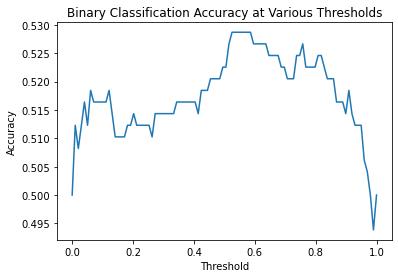

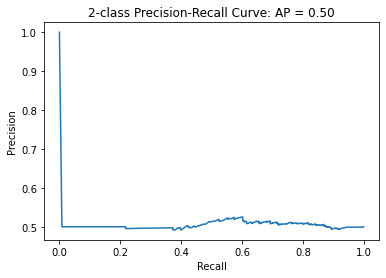

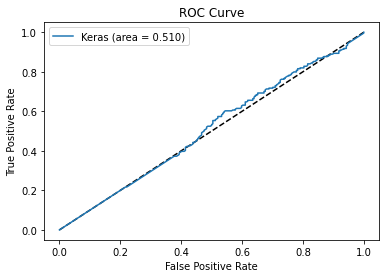

In [17]:
accuracy = []
for th in np.linspace(0, 1, 100):
    pred_labels = (pred > th)
    x = accuracy_score(pred_labels, test_labels)
    accuracy.append(x)
    
plt.figure(1)
plt.plot(np.linspace(0, 1, 100), accuracy)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Binary Classification Accuracy at Various Thresholds')

plt.figure(2)
precision, recall, thresholds = precision_recall_curve(test_labels, pred)
average_precision = average_precision_score(test_labels, pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall Curve: AP = ''{0:0.2f}'.format(average_precision))

fpr_keras, tpr_keras, thersholds_keras = roc_curve(test_labels, pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label = 'Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

plt.show()

Confusion Matrix :
[[108 136]
 [ 97 147]]
Accuracy Score : 0.5225409836065574
Report : 
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       244
           1       0.52      0.60      0.56       244

    accuracy                           0.52       488
   macro avg       0.52      0.52      0.52       488
weighted avg       0.52      0.52      0.52       488



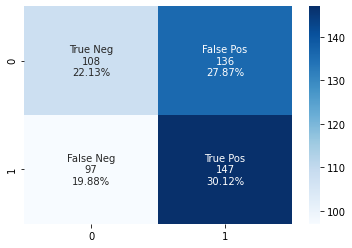

In [18]:
threshold = 0.5
pred_labels = (pred > threshold).astype(int).flatten()

cf_matrix = confusion_matrix(test_labels, pred_labels) 
  
print('Confusion Matrix :')
print(cf_matrix) 
print('Accuracy Score :', accuracy_score(test_labels, pred_labels))
print('Report : ')
print(classification_report(test_labels, pred_labels))

plt.figure(1)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap = 'Blues')
plt.show()

In [120]:
# Save prediction results with filename to csv
import re

if os.listdir('C:\\Users\\user\\results'): 
    sequence_number = int(re.findall('\d+', max(os.listdir('C:\\Users\\user\\results')))[0]) + 1
else:
    sequence_number = 1

d = {'Filenames': test_generator.filenames, 'Prediction_' + str(sequence_number): pred_labels}
results = pd.DataFrame(data = d)
file_name = 'C:\\Users\\user\\results\\results_' + str(sequence_number) + '.csv'
results.to_csv(file_name, index = False, header = True)
print(file_name)

C:\Users\user\results\results_6.csv


In [ ]:
MODELFILENAME = 'basic_alldata_0.0001_25_250_1.h5'
MODELPATH = 'C:\\Users\\user\\saved_models'
model.save(os.path.join(MODELPATH, MODELFILENAME))

In [ ]:
# write an annotated output video
# number of predictions must match number of frames in the video
OUTPUT_VIDEO_DIR = 'C:\\Users\\user\\chair_model'

def create_output_video(
    predictions,
    input_vid_location,
    out_location=OUTPUT_VIDEO_DIR,
    frame_jump = 1,
    out_name = None,
):
    """take in a video and create an output video with annotated predictions on it

    Parameters
    ----------
    predictions : list
        list of predictions for every frame in the video
    input_video_location : str
        path to saved input fideo to run on
    out_location : str
        path to write the annotated video to
    frame_jump : int
        runt/ write predictions on every nth frame, 1 would be predicting writing to every frame
    out_name : str
        override path and file name to write the video to
    Returns
    -------
    output_video_location: str
        where the annotated video was written to

    """
    # initialize the video stream, pointer to output video file, and
    # frame dimensions
    print("processing video :", input_vid_location)

    if out_name:
        outputFileName = out_name
    else:
        outputFileName = "annotated_" + os.path.basename(input_vid_location)
    output_video_location = os.path.join(out_location, outputFileName)

    vs = cv2.VideoCapture(input_vid_location)

    fps = vs.get(cv2.CAP_PROP_FPS)
    length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    if length != len(predictions):
        print("frames and video length do not match. num frames = ", length)
        return None

    writer = None
    (W, H) = (None, None)
    # loop over frames from the video file stream
    pred_count = 0
    text = "bed score prediction"
    while True:
        # read the next frame from the file
        (grabbed, frame) = vs.read()
        # if the frame was not grabbed, then we have reached the end
        # of the stream
        if not grabbed:
            break
        # if the frame dimensions are empty, grab them
        if W is None or H is None:
            (H, W) = frame.shape[:2]
        output = frame.copy()
        # draw the activity on the output frame

        if (pred_count % frame_jump) == 0:
            text = f"Chair Score: {predictions[pred_count]}"
            # print("writing prediction ", pred_count, text)
        pred_count += 1
        cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 5)
        # check if the video writer is None
        if writer is None:
            # initialize our video writer
            fourcc = cv2.VideoWriter_fourcc(*"MP4V")
            writer = cv2.VideoWriter(output_video_location, fourcc, fps, (W, H), True)

        # write the output frame to disk
        writer.write(output)
        # print("wrote frame")

    # release the file pointers
    print("[INFO] cleaning up...")
    if writer:
        writer.release()
        out = output_video_location
    else:
        out = output_img_location
    vs.release()
    return output_video_location

In [ ]:
create_output_video(pred_labels[:1350], 
                    'C:\\Users\\user\\chair_model\\test_videos\\empty_chair_90.mp4')

In [91]:
# FFMPEG tool used to identify unique frames from video samples

# !ffmpeg -i C:\\Users\\user\\chair_model\\vids\\nightInChair.mp4 -q:v 2 -vf select="eq(pict_type\,PICT_TYPE_I)" -vsync 0 C:\\Users\\user\\chair_model\\video_unique\\nightInChair_frame%03d.jpg  

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.2.1 (GCC) 20200122
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil      56. 31.100 / 56. 31.100
  li

In [9]:
import gspread 
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive',
         'https://www.googleapis.com/auth/drive.file',
         'https://www.googleapis.com/auth/spreadsheets']

#Name of our Service Account Key
google_key_file = 'C:\\Users\\user\\service_key.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

In [4]:
import seaborn as sns
tips = sns.load_dataset('tips')

In [5]:
spreadsheet_key = '1U59UTfPQn-0FEdBNLuY_PRMbfR8moP6ojuOZh3--h4s'
wks_name = 'test_data'
d2g.upload(tips, spreadsheet_key, wks_name, credentials=credentials, row_names=False)

<Worksheet 'test_data' id:1265053499>

In [8]:
workbook = gc.open_by_key(spreadsheet_key)
sheet = workbook.worksheet('test_data')
values = sheet.get_all_values()
pull_tips = pd.DataFrame(values[1:], columns = values[0])
pull_tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.5,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.0,Female,Yes,Sat,Dinner,2
241,22.67,2.0,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
